In [16]:
import numpy as np
U_pred_0 = np.load("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthOrderPDE_PinnSymReg/Combined/Train/U_pred.npy")
U_pred_1= np.load("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthOrderPDE_PinnSymReg/Cos/Train/U_pred.npy")
U_pred_2=np.load("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthOrderPDE_PinnSymReg/Exp/Train/U_pred.npy")

f= np.load("/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthEvoPINN/Sin/Train/f.npy")
t=np.linspace(0,2,500).reshape(-1,1)
x=np.linspace(-1,1,500).reshape(-1,1)
xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T

In [17]:
import pandas as pd

# Assuming you have already computed U_pred
data0 = {'x': xx.flatten(), 't': tt.flatten(), 'type': [0] * len(xx.flatten()),'U_pred': U_pred_0.flatten()}
df0 = pd.DataFrame(data0)
data1 = {'x': xx.flatten(), 't': tt.flatten(), 'type': [1] * len(xx.flatten()),'U_pred': U_pred_1.flatten()}
df1 = pd.DataFrame(data1)
data2 = {'x': xx.flatten(), 't': tt.flatten(), 'type': [2] * len(xx.flatten()),'U_pred': U_pred_2.flatten()}
df2= pd.DataFrame(data2)



In [21]:
# Concatenate the DataFrames
df_combined = pd.concat([df0, df1, df2], ignore_index=True)

# Print the combined DataFrame
print(df_combined)
# Save the combined DataFrame as CSV
df_combined.to_csv('/home/trl102/Dir/MyDailyWork/PDE/DeepXde_PDE/FifthEvoPINN/combined_data_solution.csv', index=False)



               x    t  type    U_pred
0      -1.000000  0.0     0 -0.947932
1      -0.995992  0.0     0 -0.937642
2      -0.991984  0.0     0 -0.927364
3      -0.987976  0.0     0 -0.917098
4      -0.983968  0.0     0 -0.906847
...          ...  ...   ...       ...
749995  0.983968  2.0     2 -0.002101
749996  0.987976  2.0     2 -0.003609
749997  0.991984  2.0     2 -0.005123
749998  0.995992  2.0     2 -0.006643
749999  1.000000  2.0     2 -0.008169

[750000 rows x 4 columns]


In [20]:
df_combined

,x,t,type,U_pred
0,-1.000000,0.0,0,-0.947932
1,-0.995992,0.0,0,-0.937642
2,-0.991984,0.0,0,-0.927364
3,-0.987976,0.0,0,-0.917098
4,-0.983968,0.0,0,-0.906847
...,...,...,...,...
749995,0.983968,2.0,2,-0.002101
749996,0.987976,2.0,2,-0.003609
749997,0.991984,2.0,2,-0.005123
749998,0.995992,2.0,2,-0.006643


In [47]:
# Import necessary modules
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

# Example data setup (assuming df_combined is your initial dataframe)
X = df_combined[['x', 't', 'type']]
y = df_combined['U_pred']

# Encode the 'type' column using one-hot encoding
X_encoded = pd.get_dummies(X, columns=['type'])

# Initialize the Random Forest Regressor
model_rf_10 = RandomForestRegressor(n_estimators=50, random_state=42)
# Perform 5-fold cross-validation with the full dataset
scores = cross_val_score(model_rf, X_encoded, y, cv=5, scoring='neg_mean_squared_error')

# Convert the negative mean squared error to positive and calculate RMSE
mse_scores = -scores  # Make scores positive
rmse_scores = np.sqrt(mse_scores)  # Calculate RMSE for easier interpretation

# Print results
print("5-Fold Cross-Validation RMSE Scores:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())


5-Fold Cross-Validation RMSE Scores: [0.27945248 0.08778271 0.02401869 0.17736841 0.26146196]
Average RMSE: 0.16601685207772426


In [22]:
from sklearn.model_selection import train_test_split

# Combine data with type information
df_combined['type'] = df_combined['type'].astype('category')

# Split data into features (X) and target (y)
X = df_combined[['x', 't', 'type']]
y = df_combined['U_pred']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
# Encode categorical variable 'type'
X_train_encoded = pd.get_dummies(X_train, columns=['type'])
X_test_encoded = pd.get_dummies(X_test, columns=['type'])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Encode categorical variable 'type'
X_train_encoded = pd.get_dummies(X_train, columns=['type'])
X_test_encoded = pd.get_dummies(X_test, columns=['type'])

# Build and compile the DNN model
model_dnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_dnn.compile(optimizer='adam', loss='mse')

# Train the DNN model
model_dnn.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_split=0.2)


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import numpy as np
# Encode categorical variable 'type'
X_train_encoded = pd.get_dummies(X_train, columns=['type'])
X_test_encoded = pd.get_dummies(X_test, columns=['type'])

# Define R^2 metric function
def r_square(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return 1 - SS_res/(SS_tot + tf.keras.backend.epsilon())

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)

# Build and compile the DNN model
model_dnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_dnn.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', r_square])
# Train the DNN model with early stopping
history = model_dnn.fit(X_train_encoded, y_train, epochs=100, batch_size=32, 
                        validation_split=0.20, callbacks=[early_stopping])
# Evaluate the DNN model on test data
loss, mae, mse, r2 = model_dnn.evaluate(X_test_encoded, y_test)
print("DNN - MAE:", mae)
print("DNN - MSE:", mse)
print("DNN - R^2:", r2)

# Save the DNN model
model_dnn.save("model_dnn.h5")


Epoch 1/100


/home/trl102/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


15000/15000 [==============================] - 28s 2ms/step - loss: 0.0025 - mae: 0.0313 - mse: 0.0025 - r_square: 0.9870 - val_loss: 0.0047 - val_mae: 0.0521 - val_mse: 0.0047 - val_r_square: 0.9755
Epoch 2/100
15000/15000 [==============================] - 27s 2ms/step - loss: 6.8447e-04 - mae: 0.0187 - mse: 6.8447e-04 - r_square: 0.9964 - val_loss: 0.0066 - val_mae: 0.0642 - val_mse: 0.0066 - val_r_square: 0.9657
Epoch 3/100
15000/15000 [==============================] - 26s 2ms/step - loss: 5.5399e-04 - mae: 0.0168 - mse: 5.5399e-04 - r_square: 0.9971 - val_loss: 0.0061 - val_mae: 0.0639 - val_mse: 0.0061 - val_r_square: 0.9680
Epoch 4/100
15000/15000 [==============================] - 31s 2ms/step - loss: 4.9263e-04 - mae: 0.0158 - mse: 4.9263e-04 - r_square: 0.9974 - val_loss: 0.0082 - val_mae: 0.0744 - val_mse: 0.0082 - val_r_square: 0.9568
Epoch 5/100
15000/15000 [==============================] - 25s 2ms/step - loss: 4.5772e-04 - mae: 0.0152 - mse: 4.5772e-04 - r_square: 0.997

7813/7813 [==============================] - 7s 836us/step


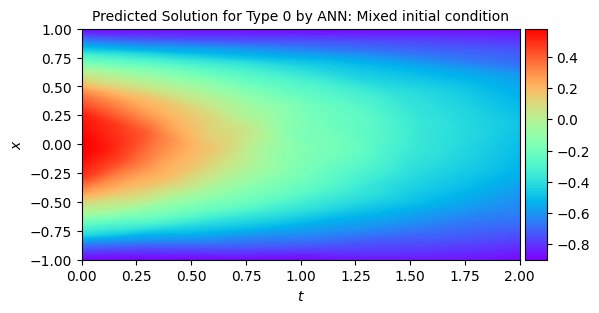

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import joblib

# Load the pre-trained Random Forest model
#model_rf = joblib.load('Random_forest_model.pkl')  # Change to your saved model's path

# Define the prediction grid
t_values = np.linspace(0, 2, 500)
x_values = np.linspace(-1, 1, 500)
xx, tt = np.meshgrid(x_values, t_values)

# Create a 2D array for prediction with 'type' set to 0
X_grid = np.column_stack((xx.flatten(), tt.flatten(), np.zeros(xx.flatten().shape)))  # 'type' is 0

# One-hot encode 'type' and ensure expected columns
X_grid_encoded = pd.get_dummies(pd.DataFrame(X_grid, columns=['x', 't', 'type']), columns=['type'])

# Ensure all expected columns are present
expected_columns = ['x', 't', 'type_0', 'type_1', 'type_2']
for col in expected_columns:
    if col not in X_grid_encoded:
        X_grid_encoded[col] = 0  # Add missing columns with default value
X_grid_encoded['type_0']=1

# Reorder columns to match the expected order
X_grid_encoded = X_grid_encoded[expected_columns]

# Predict the solution with the pre-trained Random Forest model
U_pred = model_dnn.predict(X_grid_encoded).reshape(xx.shape)

# Plotting the predicted solution for 'type 0'
fig, ax = plt.subplots(figsize=(6, 3))
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t_values.min(), t_values.max(), x_values.min(), x_values.max()],
              origin='lower', aspect='auto')

# Add a colorbar to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Set plot labels and title
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Predicted Solution for Type 0 by ANN: Mixed initial condition', fontsize=10)

# Save the plot to a file
plt.savefig('predicted_solution_type_0_ANN.eps', dpi=300)  # Save as PNG with high DPI

# Display the plot
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import joblib

# Load the pre-trained Random Forest model
#model_rf = joblib.load('Random_forest_model.pkl')  # Change to your saved model's path

# Define the prediction grid
t_values = np.linspace(0, 2, 500)
x_values = np.linspace(-1, 1, 500)
xx, tt = np.meshgrid(x_values, t_values)

# Create a 2D array for prediction with 'type' set to 0
X_grid = np.column_stack((xx.flatten(), tt.flatten(), np.zeros(xx.flatten().shape)))  # 'type' is 0

# One-hot encode 'type' and ensure expected columns
X_grid_encoded = pd.get_dummies(pd.DataFrame(X_grid, columns=['x', 't', 'type']), columns=['type'])

# Ensure all expected columns are present
expected_columns = ['x', 't', 'type_0', 'type_1', 'type_2']
for col in expected_columns:
    if col not in X_grid_encoded:
        X_grid_encoded[col] = 0  # Add missing columns with default value
X_grid_encoded['type_0']=1

# Reorder columns to match the expected order
X_grid_encoded = X_grid_encoded[expected_columns]

# Predict the solution with the pre-trained Random Forest model
U_pred = model_rf_10.predict(X_grid_encoded).reshape(xx.shape)

# Plotting the predicted solution for 'type 0'
fig, ax = plt.subplots(figsize=(6, 3))
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t_values.min(), t_values.max(), x_values.min(), x_values.max()],
              origin='lower', aspect='auto')

# Add a colorbar to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Set plot labels and title
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Predicted Solution for Type 0 by DNN: Mixed initial condition', fontsize=10)

In [25]:
# Predictions from Random Forest
y_pred_rf = model_dnn.predict(X_test_encoded)

4688/4688 [==============================] - 4s 821us/step


In [35]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_encoded, y_train)

RandomForestRegressor(random_state=42)

In [36]:
# Predictions from Random Forest
y_pred_rf = model_rf.predict(X_test_encoded)


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Calculate metrics for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Random Forest - MAE:", mae_rf)
print("Random Forest - MSE:", mse_rf)


Random Forest - MAE: 0.0002532693505970389
Random Forest - MSE: 1.7086283983542495e-07


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Calculate metrics for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


print("Random Forest - MAE:", mae_rf)
print("Random Forest - MSE:", mse_rf)
print("Random Forest - R^2:", r2_rf)


Random Forest - MAE: 0.0002532693505970389
Random Forest - MSE: 1.7086283983542495e-07
Random Forest - R^2: 0.999999144324565


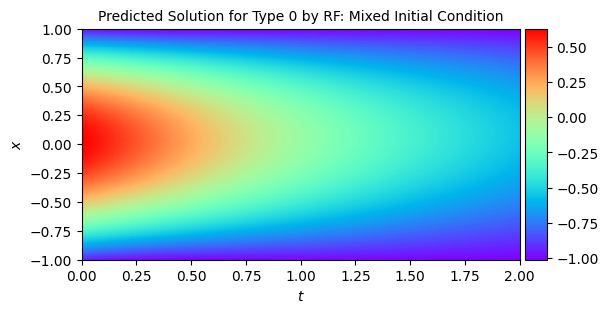

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import joblib

# Load the pre-trained Random Forest model
#model_rf = joblib.load('Random_forest_model.pkl')  # Change to your saved model's path

# Define the prediction grid
t_values = np.linspace(0, 2, 500)
x_values = np.linspace(-1, 1, 500)
xx, tt = np.meshgrid(x_values, t_values)

# Create a 2D array for prediction with 'type' set to 0
X_grid = np.column_stack((xx.flatten(), tt.flatten(), np.zeros(xx.flatten().shape)))  # 'type' is 0

# One-hot encode 'type' and ensure expected columns
X_grid_encoded = pd.get_dummies(pd.DataFrame(X_grid, columns=['x', 't', 'type']), columns=['type'])

# Ensure all expected columns are present
expected_columns = ['x', 't', 'type_0', 'type_1', 'type_2']
for col in expected_columns:
    if col not in X_grid_encoded:
        X_grid_encoded[col] = 0  # Add missing columns with default value
X_grid_encoded['type_0']=1

# Reorder columns to match the expected order
X_grid_encoded = X_grid_encoded[expected_columns]

# Predict the solution with the pre-trained Random Forest model
U_pred = model_rf.predict(X_grid_encoded).reshape(xx.shape)

# Plotting the predicted solution for 'type 0'
fig, ax = plt.subplots(figsize=(6, 3))
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t_values.min(), t_values.max(), x_values.min(), x_values.max()],
              origin='lower', aspect='auto')

# Add a colorbar to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Set plot labels and title
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Predicted Solution for Type 0 by RF: Mixed Initial Condition', fontsize=10)

# Save the plot to a file
plt.savefig('predicted_solution_type_0_RF.eps', dpi=300)  # Save as PNG with high DPI

# Display the plot
plt.show()